# Notebook to Evaluate New Bathymetry as the run comes in

## Salinity top 5 m

In [51]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [52]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [53]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [54]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [55]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [56]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X2 = X**2
    X2 = X**2
    X3 = X**3
    X4 = X**4
    X5 = X**5
    X6 = X**6
    X = np.column_stack((X, X2, X3, X4, X5, X6))
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    # print (model.params)
    return predictions, model.params['x2'], model.params['x1'], model.params['const'], systematic, nonsyst

In [57]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [58]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    if 'ferry' in pieces[0]:
        temp1['k'] = 1.5
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 1.5
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [59]:
def plot_and_stats(temp1, name):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 34
    vmin = 0
    condition = temp1.k < 5
    title = 'Salinity top 5 m'
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[condition], temp1.mod_vosaline[condition], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[condition], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[condition], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[condition], 'SA', 'mod_vosaline')
    predictions, m2, m, c, syst, nonsyst = slope_inter(temp1[condition], 'SA', 'mod_vosaline')
    tspread = spread(temp1[condition], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(temp1.SA[condition], predictions, 'r.');
    ax.arrow(3, 27, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(3, 29, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(4, 27, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(4, 29, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 27, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 29, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(3-0.2, 22, 'bias', rotation=90)
    ax.text(4-0.2, 21, 'systematic', rotation=90)
    ax.text(5-0.2, 20, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, {title}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [61]:
pieces = ('/home/sallen/202007/H201812/ObsModel_H201812_ctd_20150101_20151231.csv',
     #    '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20160101_20161231.csv',
     #    '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20150101_20151231.csv',
      #   '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20160101_20161231.csv',
      #    '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20150101_20151231.csv',
      #    '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20160101_20161231.csv',
      #    '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20150101_20151231.csv',
      #    '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20160101_20161231.csv',
      #    '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,136798,1.3,4.7,0.2,-0.75,1e+01,3.3,3.3,0.47


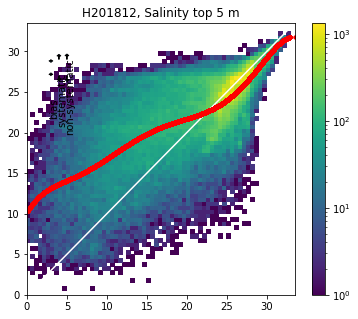

In [62]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
d201812 = plot_and_stats(temp1, 'H201812')
d201812.style.format(myformat)

In [63]:
pieces = ('/home/sallen/202007/H201905/ObsModel_H201905_ctd_20150101_20151231.csv',
       #  '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20160101_20161231.csv',
       #  '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20150101_20151231.csv',
       #  '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20160101_20161231.csv',
       #   '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20150101_20151231.csv',
       #   '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20160101_20161231.csv',
       #   '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20150101_20151231.csv',
       #   '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20160101_20161231.csv',
       #   '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,136798,1.2,4.8,0.2,-0.52,1e+01,3.3,3.4,0.47


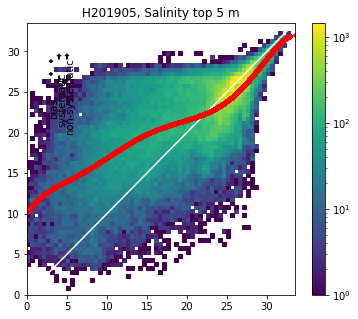

In [64]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
d201905 = plot_and_stats(temp1, 'H201905')
d201905.style.format(myformat)

In [65]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20150101-20151231.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20160101_20161231.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20160101-20161231.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170101-20170331.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170401-20170630.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170701-20170930.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20171001-20171231.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150101_20150331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150401_20150630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150701_20150930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20151001_20151231.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160101_20160331.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160301_20160630.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160601_20160930.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20161001_20161231.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170101_20170331.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170401_20170630.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170701_20170930.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20171001_20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20150101_20151231.csv',
   #       '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20160101_20161231.csv',
   #       '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,135862,1.3,4.8,0.2,-0.33,1.1e+01,3.3,3.4,0.48


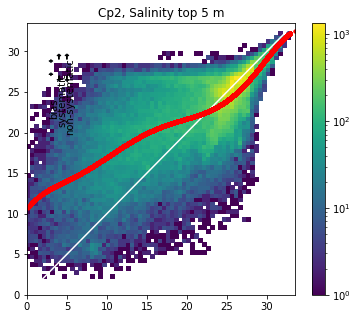

In [66]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
dCp2 = plot_and_stats(temp1, 'Cp2')
dCp2.style.format(myformat)

In [67]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20151001-20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20150101_20151231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20160101_20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20160101_20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20160101_20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20170101_20171231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20170101_20171231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20150101_20151231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20160101_20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20170101_20171231.csv'
        )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Dagain,136738,1.3,5.0,0.23,-0.98,8.8,3.6,3.4,0.49


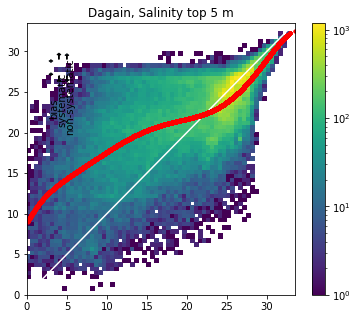

In [68]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
Dagain = plot_and_stats(temp1, 'Dagain')
Dagain.style.format(myformat)

In [69]:
pieces = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20150101_20151231.csv',
  #      '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20160101_20161231.csv',
  #      '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20150101_20151231.csv',
  #      '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20160101_20161231.csv',
  #      '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20150101_20151231.csv',
  #      '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20160101_20161231.csv',
  #      '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20170101_20171231.csv',         
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20150101_20151231.csv',     
  #       '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20160101_20161231.csv',
  #       '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-noCil,136798,1.4,4.8,0.21,-1.7,8.1,3.4,3.3,0.49


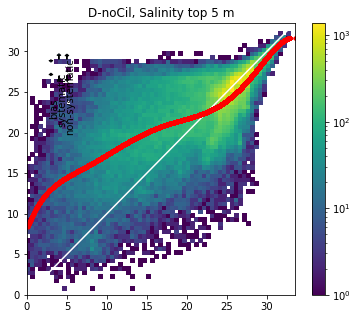

In [70]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
DnoC = plot_and_stats(temp1, 'D-noCil')
DnoC.style.format(myformat)

In [71]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20150101_20151231.csv',
      #   '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20160101_20161231.csv',
      #    '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20160101_20161231.csv',
      #   '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20160101_20161231.csv',
      #   '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20170101_20171231.csv',
      #    '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20170101_20171231.csv',
      #   '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20150101_20151231.csv',
      #   '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20160101_20161231.csv',
      #   '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,136798,1.3,4.9,0.21,-0.21,1.1e+01,3.4,3.4,0.48


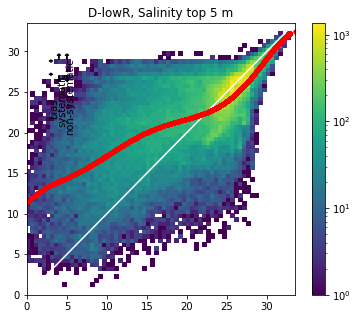

In [72]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
DlowR = plot_and_stats(temp1, 'D-lowR')
DlowR.style.format(myformat)

In [87]:
pieces = (
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20150101_20151231.csv',
 #        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20160101_20161231.csv',
 #         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TSPUG_20150101-20151231.csv',
 #        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20160101_20161231.csv',
 #        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20150101_20151231.csv',
  #       '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20160101_20161231.csv',
  #       '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150101_20150331.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150401_20150630.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150701_20150930.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20151001_20151231.csv',
   #      '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160101_20160331.csv',
   # '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160401_20160630.csv',
   # '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160701_20160930.csv',
   # '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20161001_20161231.csv',
   #      '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20170101_20171231.csv'
)

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modCp3 = plot_and_stats(temp1, 'Cp3')
modCp3.style.format(myformat)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp3,135862,1.8,5.0,0.22,-0.8,9.7,3.7,3.2,0.52


In [75]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
        #  '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
        #  '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20150101_20151231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,136798,1.8,5.0,0.22,0.035,1.1e+01,3.7,3.3,0.52


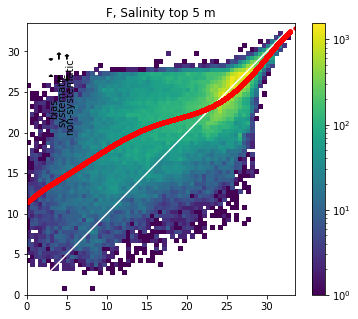

In [76]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modF = plot_and_stats(temp1, 'F')
modF.style.format(myformat)

In [81]:
pieces = ('/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20150101_20150331.csv', 
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20150401_20150630.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20150701_20150930.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20151001_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20150101_20150331.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20150401_20150630.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20150701_20150930.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20151001_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20150101_20150331.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20150401_20150630.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20150701_20150930.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20151001_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150101_20150331.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150401_20150630.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150701_20150930.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20151001_20151231.csv',
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Gp1,135764,1.8,4.5,0.18,0.31,1.4e+01,3.3,3.0,0.48


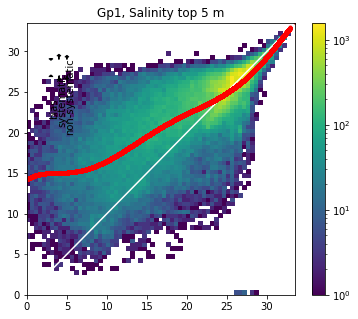

In [85]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modGp1 = plot_and_stats(temp1, 'Gp1')
modGp1.style.format(myformat)

In [83]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [84]:
alltogether = pd.concat([d201905, dCp2, Dagain, DnoC, DlowR, modCp3, modF, modGp1], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,136798,1.2,4.8,0.2,-0.52,1e+01,3.3,3.4,0.47
Cp2,135862,1.3,4.8,0.2,-0.33,1.1e+01,3.3,3.4,0.48
Dagain,136738,1.3,5.0,0.23,-0.98,8.8,3.6,3.4,0.49
D-noCil,136798,1.4,4.8,0.21,-1.7,8.1,3.4,3.3,0.49
D-lowR,136798,1.3,4.9,0.21,-0.21,1.1e+01,3.4,3.4,0.48
Cp3,119921,2.1,5.3,0.25,-1.9,8.7,4.0,3.4,0.48
F,136798,1.8,5.0,0.22,0.035,1.1e+01,3.7,3.3,0.52
Gp1,119921,2.1,4.8,0.2,0.32,1.4e+01,3.6,3.1,0.44


So far, so good for Gp1. (no ferry)

In [36]:
And good for Gp1 ferry only compared to Cp3

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,Fluor,...,temperature (degrees_Celcius),salinity (g/kg),turbidity (NTU),o2_concentration_corrected (ml/l),oxygen (uM),conservative temperature (oC),indf_ptrc_T,ih_ptrc_T,indf_grid_T,ih_grid_T
0,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,0.991487,25.146111,6.992043,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,2.082117,25.243427,7.082535,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,2.974446,25.319752,7.117362,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,3.965919,25.378789,7.148240,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015.0,1.0,9.0,16.994444,49.328833,-124.080833,4.957386,25.423254,7.173524,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326807,NaN,NaN,NaN,NaN,49.216750,-123.793333,NaN,24.274913,NaN,NaN,...,20.222367,24.274913,14.487867,6.471354,289.017151,20.553822,89.0,23.0,89.0,23.0
326808,NaN,NaN,NaN,NaN,49.216900,-123.801350,NaN,24.272384,NaN,NaN,...,20.419550,24.272384,14.758067,6.482401,289.510515,20.754024,89.0,23.0,89.0,23.0
326809,NaN,NaN,NaN,NaN,49.217000,-123.809350,NaN,24.307717,NaN,NaN,...,20.440467,24.307717,15.015400,6.492939,289.981156,20.774163,89.0,23.0,89.0,23.0
326810,NaN,NaN,NaN,NaN,49.216317,-123.817233,NaN,24.324730,NaN,NaN,...,20.165100,24.324730,15.285600,6.525314,291.427034,20.494183,89.0,23.0,89.0,23.0


In [37]:
pieces = (
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150101_20150331.csv',
      
         )

In [38]:
temp1 = read_pieces(pieces)

In [43]:
temp1[temp1['time (UTC)'].to_datetime() < dt.datetime(2015, 7, 1)]

AttributeError: 'Series' object has no attribute 'to_datetime'